In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from motion_utils import calculate_motion_vectors, combine_frames_and_motion_vectors


In [2]:
# custom loss function, taking into account the RGB values
# 효과는 크게 없었지만, 논리적으로는 맞는 부분인 것 같음.

from tensorflow.keras import backend as K

# Custom loss function that applies MSE specifically to RGB channels
def mse_rgb(y_true, y_pred):
    # y_true and y_pred are assumed to be in shape (batch_size, height, width, 3)
    return K.mean(K.square(y_true - y_pred), axis=-1)

In [3]:
from tensorflow.keras import layers, models

def build_model(input_shape, output_frames):
    """
    Builds a CNN-based encoder-decoder model for animation frame prediction.
    
    Parameters:
    input_shape (tuple): The shape of the input frame (height, width, channels).
    output_frames (int): The number of frames to generate as output.
    
    Returns:
    model: The compiled Keras model.
    """
    # Encoder
    encoder_input = layers.Input(shape=input_shape, name='encoder_input')
    
    # CNN layers to encode the first frame
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(encoder_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(x)
    
    # Flatten the output of the convolutional layers
    x = layers.Flatten()(x)

    # Latent representation
    latent = layers.Dense(512, activation='relu', name='latent_vector')(x)

    # Decoder (generate multiple frames)
    decoder_output = layers.Dense(output_frames * input_shape[0] * input_shape[1] * input_shape[2], activation='sigmoid')(latent)
    
    # Reshape to the desired output shape (frames, height, width, channels)
    decoder_output = layers.Reshape((output_frames, input_shape[0], input_shape[1], input_shape[2]), name='decoder_output')(decoder_output)

    # Build and compile the model
    model = models.Model(encoder_input, decoder_output, name='frame_predictor_model')
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [4]:
# Define input shape for 128x128x3 images
input_shape = (128, 128, 3)  # Height, Width, Channels
output_frames = 9  # Number of frames to predict

# Build the model
model = build_model(input_shape, output_frames)

# Print model summary
model.summary()

Model: "frame_predictor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 2

In [6]:
def process_sprite_data(sprite_sheet_paths, num_frames):
    """
    Processes sprite sheets and returns animation data without saving individual images.
    
    Parameters:
    sprite_sheet_paths (list): List of paths to the sprite sheet images.
    num_frames (int): Total number of frames (sprites) in the sprite sheet.
    
    Returns:
    X (numpy array): Array of input frames (first frame of each animation sequence).
    Y (numpy array): Array of output frames (remaining frames of each animation sequence).
    """
    # Initialize lists for input (X) and output (Y) frames
    X = []
    Y = []
    
    # Process each sprite sheet in the provided paths
    for i in range(len(sprite_sheet_paths)):
        sprite_sheet = Image.open(sprite_sheet_paths[i])
        
        # Get sprite sheet dimensions
        sheet_width, sheet_height = sprite_sheet.size
        
        # Calculate the width and height of each frame
        frame_width = sheet_width // num_frames
        frame_height = sheet_height  # Height of each frame is the same as the height of the sprite sheet
        
        # Loop through each frame in the sprite sheet
        for frame_num in range(num_frames):
            # Calculate the coordinates of the sprite in the sprite sheet
            left = frame_num * frame_width
            upper = 0
            right = left + frame_width
            lower = frame_height
            
            # Crop the sprite from the sprite sheet
            frame = sprite_sheet.crop((left, upper, right, lower))
            
            # Resize to 128x128 if needed and convert to RGB
            frame = frame.convert('RGB').resize((128, 128))
            
            # Normalize pixel values to [0, 1]
            frame_array = np.array(frame) / 255.0
            
            # Append the first frame to X and the remaining ones to Y
            if frame_num == 0:
                X.append(frame_array)  # The first frame goes into X
            else:
                if len(Y) <= i:  # Initialize the sublist for Y if necessary
                    Y.append([])
                Y[i].append(frame_array)  # Subsequent frames go into Y
    
    return np.array(X), np.array(Y)

sprite_sheet_paths = [
    './data/Walk/Walk_City_men_1_10f.png',
    './data/Walk/Walk_City_men_2_10f.png',
    './data/Walk/Walk_City_men_3_10f.png',
    './data/Walk/Walk_Gangsters_1_10f.png',
    './data/Walk/Walk_Gangsters_2_10f.png',
    './data/Walk/Walk_Gangsters_3_10f.png'
] 
num_frames = 10  # Number of frames in the sprite sheet
X, Y = process_sprite_data(sprite_sheet_paths, num_frames)

print(f"X shape: {X[1:].shape}")  # Should be (num_sequences, 128, 128, 3)
print(f"Y shape: {Y[1:].shape}")  # Should be (num_sequences, 9, 128, 128, 3)

X shape: (5, 128, 128, 3)
Y shape: (5, 9, 128, 128, 3)


In [12]:
# 이미지와 모션 벡터 결합
# motion_vectors = calculate_motion_vectors(X[1:])  # X는 프레임 배열
# X_combined = combine_frames_and_motion_vectors(X[1:], motion_vectors)

# 모델 생성 및 훈련
# input_shape = (128, 128, 5)  # 128x128 이미지에 모션 벡터 포함
# output_frames = 9  # 출력 프레임 수

model.fit(X, Y, epochs=50, batch_size=32, validation_split==0.1)


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.2442 - mae: 0.4924
Epoch 2/10
1/1 [==============================] - 0s 396ms/step - loss: 0.2440 - mae: 0.4923
Epoch 3/10
1/1 [==============================] - 1s 694ms/step - loss: 0.2433 - mae: 0.4916
Epoch 4/10
1/1 [==============================] - 1s 783ms/step - loss: 0.2366 - mae: 0.4846
Epoch 5/10
1/1 [==============================] - 1s 609ms/step - loss: 0.1819 - mae: 0.4230
Epoch 6/10
1/1 [==============================] - 0s 424ms/step - loss: 0.0313 - mae: 0.1559
Epoch 7/10
1/1 [==============================] - 1s 734ms/step - loss: 0.0115 - mae: 0.0202
Epoch 8/10
1/1 [==============================] - 1s 640ms/step - loss: 0.0139 - mae: 0.0214
Epoch 9/10
1/1 [==============================] - 0s 458ms/step - loss: 0.0162 - mae: 0.0230
Epoch 10/10
1/1 [==============================] - 1s 676ms/step - loss: 0.0173 - mae: 0.0234


In [13]:
refine_train = []

for i in range(X.shape[0]):
    predicted_frames = model.predict(np.expand_dims(X[i], axis=0))  # Add batch dimension
    predicted_frames = predicted_frames.squeeze()  # Remove the batch dimension if needed
    merged_frames = np.concatenate((np.expand_dims(X[i], axis=0), predicted_frames), axis=0)
    refine_train.append(np.expand_dims(merged_frames, axis=0))
    
# print(f"Predicted frames shape: {predicted_frames.shape}")  # Should be (9, 128, 128, 3)

# # Optionally, save the predicted frames or display them
# for i in range(predicted_frames.shape[0]):
#     frame = (predicted_frames[i] * 255).astype(np.uint8)  # Convert back to [0, 255]

1/1 [==============================] - 0s 53ms/step


In [15]:
refine_train = np.concatenate(refine_train, axis=0) 
refine_train.shape

(6, 10, 128, 128, 3)

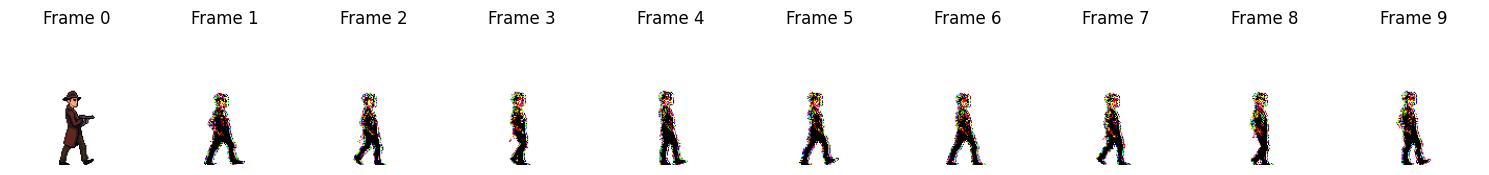

In [16]:
def display_predicted_frames(predicted_frames):
    """
    Display predicted frames using Matplotlib.

    Parameters:
    predicted_frames (numpy array): Array of predicted frames.
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure to display the frames
    plt.figure(figsize=(15, 5))

    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)  # Create a subplot for each frame
        plt.imshow(predicted_frames[i])  # Display the frame
        plt.axis('off')  # Hide the axes
        plt.title(f'Frame {i}')  # Optional: add title to each frame

    plt.tight_layout()  # Adjust subplots to fit in to the figure area.
    plt.show()  # Show the plot

display_predicted_frames(refine_train[3])